In [21]:
%load_ext autoreload
%autoreload 2

import rateStudy as rS
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Initialize Swift data

In [13]:
from swift import readSwiftData, getSwiftflx

In [14]:
info = readSwiftData()

In [15]:
getSwiftflx(info, grbType="long")

Swift flux data is saved in ./swift/Swift_flux_long.npy.


## 1. Print log(N) - log(S) curve

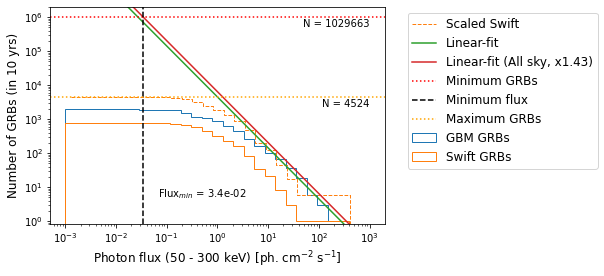

In [73]:
logNlogS = rS.fit_logNlogS_curve(plotting=True, grbType="long")

## 2. Synthesize bursts based on the log N - log S curve.

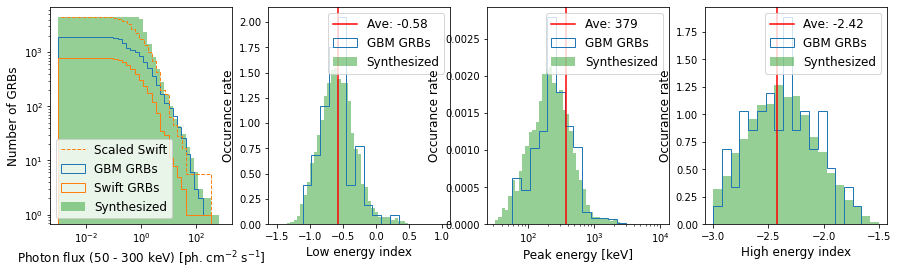

In [45]:
table = rS.generate_bursts(logNlogS, plotting=True, grbType="long")

## 3. Loading instrument IRFs and backgrounds

In [75]:
inst = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_UC.txt", 
                     bkg = "./AMEGO-X/bg_rates_pixel_250um.root")

In [76]:
inst

E_low,E_high,EA,background
MeV,MeV,cm2,ph / s
float64,float64,float64,float64
0.079,0.1,5.718999999999999,2.2716666666666665
0.1,0.125,29.351499999999998,20.871388888888887
0.125,0.158,87.1115,50.975833333333334
0.158,0.199,174.9105,61.799166666666665
0.199,0.251,283.194,52.754444444444445
0.251,0.316,398.712,46.61666666666666
0.316,0.398,488.4125,38.92111111111112
0.398,0.501,532.9395,34.52222222222221


## 4. Estimate the GRB rate

In [2]:
#er = rS.EstimateRate(inst)
er = rS.EstimateRate(load_status="cos0.8") # When a simulation is performed, the status is saved and loaded.

### 4.1 Single run

In [7]:
output = er.forward_folding(verbose=True, return_output=True)

[Log] Generating burst spectra



[Log] Forward folding the burst spectra


/Users/dtak/Software/miniconda3/lib/python3.8/site-packages/astropy/table/table.py:2769: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



[Log] Analysis done. The estimated rate is 75.7 GRBs/yr (SNR > 6.5)


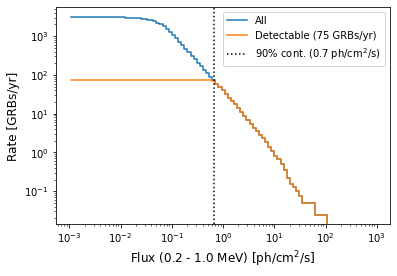

In [8]:
rS.plotFluxHist(output)

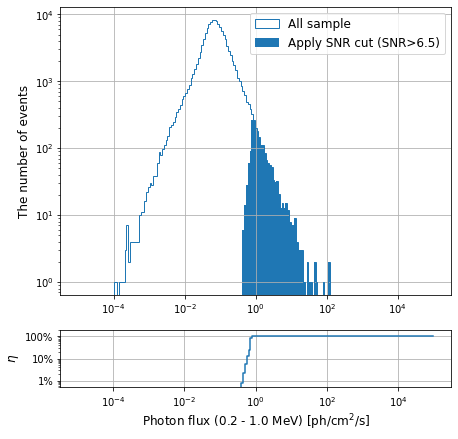

In [3]:
rS.plotEfficiency(er.output)

### 4.2 Simulation - multiple runs

In [9]:
er.simulation(runs=100)


[Log] Analysis Done (status: 'past'). The estimated rate is 24.5 +/- 3.8 GRBs/yr


AxesSubplot(0.125,0.125;0.775x0.755)


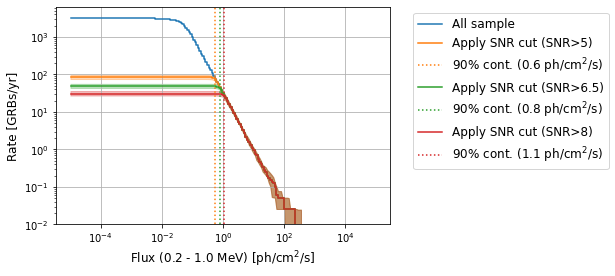

In [111]:
rS.plotFluxHist(er.output_sim, snr_cuts = [5, 6.5, 8])

In [52]:
rS.plotRateHist(er.rate_sim)

AttributeError: 'EstimateRate' object has no attribute 'rate_sim'

## 5. Applications

### Study 1. Single site rate

In [50]:
single_site = {"E_low": 25*u.keV, "E_high": 100*u.keV, "EA": 2600*(u.cm**2), "background": 28131*u.ph/u.s}
single_site = rS.dict_to_table(single_site)

In [51]:
er = rS.EstimateRate(grbType="long")
output = er.forward_folding(inst_table=single_site, verbose=True, return_output=True)

[Log] Generating burst spectra



[Log] Forward folding the burst spectra



[Log] Analysis done. The estimated rate is 288.1 GRBs/yr (SNR > 6.5)


In [47]:
er.simulation(runs=100, inst_table=single_site, save_status="single")


[Log] Analysis Done (status: 'single'). The estimated rate is 112.3 +/- 4.1 GRBs/yr


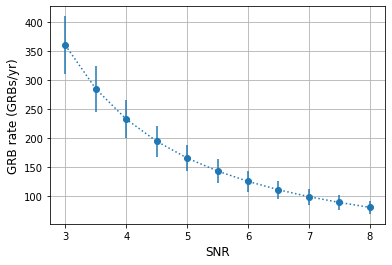

In [9]:
rate_single = []
for snr_cut in [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]:
    rate = er.calc_rate(er.snr_sim, snr_cut = snr_cut)
    rate_single.append([snr_cut, np.average(rate), np.std(rate)])
rate_single = np.asarray(rate_single)

plt.errorbar(rate_single[:,0], rate_single[:,1], yerr=rate_single[:,2],  marker="o", ls=":")
plt.xlabel("SNR", fontsize=12)
plt.ylabel("GRB rate (GRBs/yr)", fontsize=12)
plt.grid()

In [5]:
er = rS.EstimateRate(load_status="single")

In [8]:
np.average(er.calc_rate(er.snr_sim, snr_cut=3))

360.2119999999999

### Study 2. Multiple trigger flags

In [5]:
er = rS.EstimateRate()
bursts = er.create_spectra()
inst_UC = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_UC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root")
out_normal = er.forward_folding(burst_table=bursts, inst_table=inst_UC, return_output=True)
single_site = {"E_low": 25*u.keV, "E_high": 100*u.keV, "EA": 3550*(u.cm**2), "background": 25577*u.ph/u.s}
single_site = rS.dict_to_table(single_site)
out_single = er.forward_folding(burst_table=bursts, inst_table=single_site, return_output=True)
inst_TC = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_TC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root", evttype="TC")
out_TC = er.forward_folding(burst_table=bursts, inst_table=inst_TC, return_output=True)

print("Compton (SNR > 6.5): {:.1f} GRBs/yr".format(er.calc_rate(out_normal["snr"], snr_cut = 6.5)))
print("Compton (SNR > 5) AND single-site (SNR >5): {:.1f} GRBs/yr ".format(sum((out_single["snr"]>5)*(out_normal["snr"]>5))*er.FoV))
print("Tracked Compton (SNR > 3): {:.1f} GRBs/yr ".format(er.calc_rate(out_TC["snr"], snr_cut = 3)))

/Users/dtak/Research/AMEGO/rate_study/rateStudy.py:480: RuntimeWarning: invalid value encountered in true_divide
  return np.asarray([max(s) for s in np.nan_to_num(cnts/np.sqrt(cnts+bkg))])


Compton (SNR > 6.5): 58.6 GRBs/yr
Compton (SNR > 5) AND single-site (SNR >5): 65.2 GRBs/yr 
Tracked Compton (SNR > 3): 51.3 GRBs/yr 


In [2]:
single_site = {"E_low": 25*u.keV, "E_high": 100*u.keV, "EA": 3550*(u.cm**2), "background": 25577*u.ph/u.s}
single_site = rS.dict_to_table(single_site)
inst_UC = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_UC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root")
inst_TC = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_TC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root", evttype="TC")
er = rS.EstimateRate()

bursts = er.create_spectra()


In [3]:
out_UC = er.forward_folding(burst_table=bursts, inst_table=inst_UC, return_output=True, verbose=True)

In [4]:
out_SS = er.forward_folding(burst_table=bursts, inst_table=single_site, return_output=True, verbose=True)

[Log] Forward folding the burst spectra



[Log] Analysis done. The estimated rate is 103.7 GRBs/yr (SNR > 6.5)


In [5]:
er.calc_rate(out_UC["snr"], snr_cut = 6.5)

46.95

In [74]:
len(out_UC["snr"])

126162

In [84]:
for


120.325

In [85]:
ave = []
for i in range(100):
    ave.append(sum((outSS[i]["snr"]>8)+(outUC[i]["snr"]>6.5)+((outUC[i]["snr"]>5)*(outSS[i]["snr"]>5))+(outTC[i]["snr"]>3))*er.FoV)

In [87]:
np.std(ave)

15.675420797780836

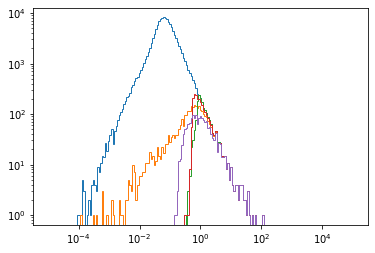

In [41]:
ys, xs, etc = plt.hist(outUC[0]["flux"], np.logspace(-5, 5, 200), histtype="step", label="All sample")
y1, x1, etc = plt.hist(outUC[0]["flux"][outSS[0]["snr"]>8], np.logspace(-5, 5, 200), histtype="step", label="All sample")
y2, x1, etc = plt.hist(outUC[0]["flux"][outUC[0]["snr"]>6.5], np.logspace(-5, 5, 200), histtype="step", label="All sample")
y3, x1, etc = plt.hist(outUC[0]["flux"][(outUC[0]["snr"]>5)*(outSS[0]["snr"]>5)], np.logspace(-5, 5, 200), histtype="step", label="All sample")
y4, x1, etc = plt.hist(outUC[0]["flux"][outTC[0]["snr"]>3], np.logspace(-5, 5, 200), histtype="step", label="All sample")

plt.xscale("log")
plt.yscale("log")

In [44]:
eff1 = y1/ys
eff1 = np.nan_to_num(eff1)
eff2 = y2/ys
eff2 = np.nan_to_num(eff2)
eff3 = y3/ys
eff3 = np.nan_to_num(eff3)
eff4 = y4/ys
eff4 = np.nan_to_num(eff4)

<ipython-input-44-07e6ae3e762a>:1: RuntimeWarning: invalid value encountered in true_divide
  eff1 = y1/ys
<ipython-input-44-07e6ae3e762a>:4: RuntimeWarning: invalid value encountered in true_divide
  eff2 = y2/ys
<ipython-input-44-07e6ae3e762a>:7: RuntimeWarning: invalid value encountered in true_divide
  eff3 = y3/ys
<ipython-input-44-07e6ae3e762a>:9: RuntimeWarning: invalid value encountered in true_divide
  eff4 = y4/ys


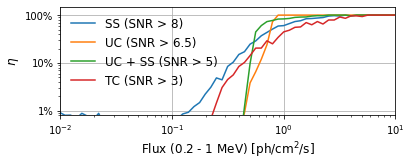

In [73]:
plt.figure(figsize=(6, 2))
plt.plot(center_pt(xs), eff1, label="SS (SNR > 8)")
plt.plot(center_pt(xs), eff2, label="UC (SNR > 6.5)")
plt.plot(center_pt(xs), eff3, label="UC + SS (SNR > 5)")
plt.plot(center_pt(xs), eff4, label="TC (SNR > 3)")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 10)
plt.yticks([0.01, 0.1, 1], ["1%", "10%", "100%"])
plt.ylim(0.008, 1.5)
plt.xlabel(r"Flux (0.2 - 1 MeV) [ph/cm$^2$/s]", fontsize=12)
plt.ylabel(r"$\eta$", fontsize=12)
plt.legend(fontsize = 12, frameon=False)
plt.grid()

In [18]:
from tqdm.notebook import trange
outUC = []
rateUC = []
outSS = []
rateUCSS = []
outTC = []
rateTC = []
single_site = {"E_low": 25*u.keV, "E_high": 100*u.keV, "EA": 3550*(u.cm**2), "background": 25577*u.ph/u.s}
single_site = rS.dict_to_table(single_site)
inst_UC = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_UC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root")
inst_TC = rS.make_table(eff = "./AMEGO-X/noLowHits_Aeff_Cos0.8_TC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root", evttype="TC")
er = rS.EstimateRate()

for i in trange(100):
    bursts = er.create_spectra()
    out_UC = er.forward_folding(burst_table=bursts, inst_table=inst_UC, return_output=True)
    out_SS = er.forward_folding(burst_table=bursts, inst_table=single_site, return_output=True)
    out_TC = er.forward_folding(burst_table=bursts, inst_table=inst_TC, return_output=True)
    
    rateUC.append(er.calc_rate(out_UC["snr"], snr_cut = 6.5))
    rateUCSS.append(sum((out_SS["snr"]>5)*(out_UC["snr"]>5))*er.FoV)
    rateTC.append(er.calc_rate(out_TC["snr"], snr_cut = 3))
    
    outUC.append(out_UC)
    outSS.append(out_SS)
    outTC.append(out_TC)
    
    
rateUC = np.asarray(rateUC)
rateUCSS = np.asarray(rateUCSS)
rateTC = np.asarray(rateTC)

np.save("./output/outUC", outUC)
np.save("./output/outSS", outSS)
np.save("./output/outTC", outTC)

NameError: name 'rate1' is not defined

In [19]:

np.save("./output/outUC", outUC)
np.save("./output/outSS", outSS)
np.save("./output/outTC", outTC)

Compton (SNR > 6.5): 48.6 +/- 7.0 GRBs/yr
Compton + Single site (SNR > 5): 59.5 +/- 8.7 GRBs/yr


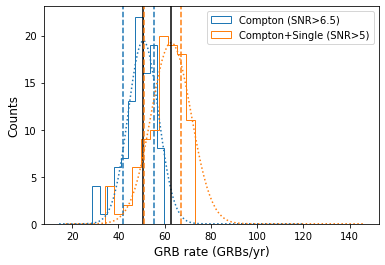

In [24]:
rS.plotRateHist(rateUC, label="UC (SNR>6.5)")
rS.plotRateHist(rateUCSS, label="UC+SS (SNR>5)")
rS.plotRateHist(rateTC, label="TC (SNR>3)")

### Study 3. Rate versus angle

In [3]:
from tqdm.notebook import tqdm
sample = rS.effective_area("./AMEGO-X/noLowHits_Aeff_Cos1.0_UC.txt")
bkg = rS.bkg_from_ROOT("./AMEGO-X/bg_rates_pixel_250um.root", eLowEdges = sample[:,0], eHighEdges= sample[:,1], evttype="UC")
bursts = rS.generate_bursts(verbose=False)
for angle in tqdm(np.linspace(0, 1.0, 11).astype("str")):
    angle = angle[:3]
    eff = rS.effective_area("./AMEGO-X/noLowHits_Aeff_Cos{}_UC.txt".format(angle))
    inst = rS.make_table(eff, bkg)
    er = rS.EstimateRate(inst)
    er.forward_folding(burst_table = bursts, verbose=False)
    print("Angle: ", angle, ", Rate: {:.1f}".format(er.rate))

Angle:  0.0 , Rate: 17.3
Angle:  0.1 , Rate: 31.0
Angle:  0.2 , Rate: 32.8
Angle:  0.3 , Rate: 34.5
Angle:  0.4 , Rate: 36.3
Angle:  0.5 , Rate: 38.3
Angle:  0.6 , Rate: 40.9
Angle:  0.7 , Rate: 44.8
Angle:  0.8 , Rate: 48.6
Angle:  0.9 , Rate: 54.1
Angle:  1.0 , Rate: 63.4



In [5]:
sample = rS.effective_area("./AMEGO-X/noLowHits_Aeff_Cos1.0_UC.txt")
bkg = rS.bkg_from_ROOT("./AMEGO-X/bg_rates_pixel_250um.root", eLowEdges = sample[:,0], eHighEdges= sample[:,1], evttype="UC")

for angle in tqdm(np.linspace(0, 1.0, 11).astype("str")):
    angle = angle[:3]
    eff = rS.effective_area("./AMEGO-X/noLowHits_Aeff_Cos{}_UC.txt".format(angle))
    inst = rS.make_table(eff, bkg)
    er = rS.EstimateRate(inst)
    er.simulation(runs=20, save_status="cos"+angle)


[Log] Analysis Done (status: 'cos0.0'). The estimated rate is 16.7 +/- 2.7 GRBs/yr



[Log] Analysis Done (status: 'cos0.1'). The estimated rate is 30.7 +/- 4.4 GRBs/yr



[Log] Analysis Done (status: 'cos0.2'). The estimated rate is 32.0 +/- 5.2 GRBs/yr



[Log] Analysis Done (status: 'cos0.3'). The estimated rate is 35.5 +/- 4.7 GRBs/yr



[Log] Analysis Done (status: 'cos0.4'). The estimated rate is 37.4 +/- 4.7 GRBs/yr



[Log] Analysis Done (status: 'cos0.5'). The estimated rate is 37.3 +/- 5.7 GRBs/yr



[Log] Analysis Done (status: 'cos0.6'). The estimated rate is 40.5 +/- 7.8 GRBs/yr



[Log] Analysis Done (status: 'cos0.7'). The estimated rate is 46.4 +/- 4.5 GRBs/yr



[Log] Analysis Done (status: 'cos0.8'). The estimated rate is 47.5 +/- 9.3 GRBs/yr



[Log] Analysis Done (status: 'cos0.9'). The estimated rate is 55.2 +/- 8.4 GRBs/yr



[Log] Analysis Done (status: 'cos1.0'). The estimated rate is 64.0 +/- 8.1 GRBs/yr



In [121]:
rate_tot_6_5 = []
rate_tot_5 = []
rate_tot_8 = []
for angle in np.linspace(0, 1.0, 11).astype("str"):
    angle = angle[:3]
    er = rS.EstimateRate(load_status="cos{}".format(angle))
    rate_tot_6_5.append([angle, np.average(er.rate_sim), np.std(er.rate_sim)])
    temp = [er.calc_rate(out["snr"], snr_cut=5) for out in er.output_sim]
    rate_tot_5.append([angle, np.average(temp), np.std(temp)])
    temp = [er.calc_rate(out["snr"], snr_cut=8) for out in er.output_sim]
    rate_tot_8.append([angle, np.average(temp), np.std(temp)])
    
rate_tot_6_5 = np.asarray(rate_tot_6_5).astype(float)
rate_tot_5 = np.asarray(rate_tot_5).astype(float)
rate_tot_8 = np.asarray(rate_tot_8).astype(float)

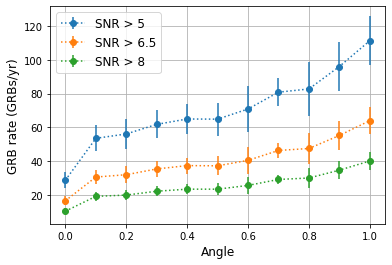

In [123]:
plt.errorbar(rate_tot_5[:,0], rate_tot_5[:,1], yerr=rate_tot_5[:,2], label="SNR > 5", marker="o", ls=":")
plt.errorbar(rate_tot_6_5[:,0], rate_tot_6_5[:,1], yerr=rate_tot_6_5[:,2], label="SNR > 6.5", marker="o", ls=":")
plt.errorbar(rate_tot_8[:,0], rate_tot_8[:,1], yerr=rate_tot_8[:,2], label="SNR > 8", marker="o", ls=":")

plt.xlabel("Angle", fontsize=12)
plt.ylabel("GRB rate (GRBs/yr)", fontsize=12)
plt.legend(fontsize=12, loc=2)
plt.grid()